# Assignment 9
===================

Name : Nihar Kanungo Batch : 6:30 AM , Sunday

Background :
============
Artificial Intelligence has been evolved and gone through many variety of changes in the recent past. The methods which we were using before 2-3 years are no more favourites and the ones we are using today may not be used after few years. This happens as there are continious improvements happening over and over again . Before few years machine learning and artificial intelligence was more a black box and the data scientists were chosing between models to perform their task , however with the more Interpretability and explainable AI features it's not easy to understand how the model performs and what are those contributes what it contributes.

The Explainable AI and model interpretability
--------------------------------------------------

1. The goal of transparency and explanations is to identify the failure modes.
2. the goal is to establish appropriate trust and confidence in users
3. when AI is significantly stronger than humans  the goal of explanations is in machine teaching 

Gradcam
-----------

![](images/Gradcam.png)

Class activation maps are a simple technique to get the discriminative image regions used by a CNN to identify a specific class in the image. In other words, a class activation map (CAM) lets us see which regions in the image were relevant to this class. CAM can be applied to a specific sturtcure of the network where as Gradcam generelizes CAM to be able to apply it with existing networks. We are discussing more on this little after

Cutout
----------

![](images/cutout.png)

Cutout is the simplest yet most efficient generalization technique available as of now. We may say that the idea is in the similar lines of the Dropout but very much effective than the dropouts. In this technique a portion of the image is cut by allowing the network to work harder to learn looking at the other parts of the image . This way it ensures that the network is not over trained. The hyper parameters allows the user to set the choose the amount of cutout to be made for each image. The most effective way to fill the portion of the image is by filling with the mean of the image as with this the mean of the new image will be the same as the old one . We can also try to implement median or mode and see the impact. BUt for now let's go ahead with mean . 


Input
----------
1) 60000 images (10 Class)

2) The Images are already segreegated as Train and Test Data with the respective target values

3) Fixed images on which we can apply gradcam and cutout

Environment
---------------
Development - Colab GPU , Jupyter Notebook Repository : Github

Algorithm
-------------
Sequential API Model

Convolutional Neural Network (2D)

Maxpooling
GlobalAverage Pooling

Softmax Activation function

loss Function : Categorical Crossentropy

Optimizer=Adam, SGD

Metrics=accuracy

Batch Normalization

Drop Out

Image Normalization

L2 Regularization

Parameters
Batch Size - Variable

Epochs - Variable

Kernel Size - Variable

Number of Kernels - Variable

Learning Rate regularization coefficient

Conditions
----------
1. To show that the heatmap is getting generated and shows the area of the image which is being learnt by the network by super imposing on top of the image 
2. By showing that cutout forces the network not to look at a specific portion of the image rather many more parts of the image 


Import all necessary libraries
--------------------------------

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


Load the CIFAR 10 images into the notebook 
---------------------------------------------
The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Computer algorithms for recognizing objects in photos often learn by example. CIFAR-10 is a set of images that can be used to teach a computer how to recognize objects. Since the images in CIFAR-10 are low-resolution (32x32), this dataset can allow researchers to quickly try different algorithms to see what works. Various kinds of convolutional neural networks tend to be the best at recognizing the images in CIFAR-10. CIFAR-10 is a labeled subset of the 80 million tiny images dataset. When the dataset was created, students were paid to label all of the images.

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


Display the Images which will be used for interpretability purpose
-------------------------------------------------------------------
Here we are taking 10 images (one from each class) from the validation set to predict using the trained network . We will also run the gradcam code with and without cutout to show the difference in how the model learns in both the cases.

Here we are storing the index of the images to be used later 

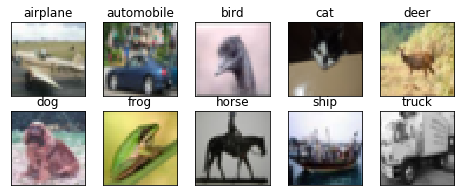

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
future_index = [None] * 10
future_image_num = [None] * 10
future_im = [None] * 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(test_labels[:]==i)[0]
    future_index[i] = idx
    features_idx = test_features[idx,::]
    img_num = np.random.randint(features_idx.shape[2])
    #print(img_num)
    future_image_num[i] = img_num
    im = features_idx[img_num]
    future_im[i] = im
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Function to define the Model history and Plot chart
-----------------------------------------------------
The Parameters of the model is a key information to quickly visualize how the model performed . Analysis of the

Training Accuracy vs Validation Accuracy and

Training Loss vs Validation Loss

would give a great understanding of the model performance

Writting a custom function helps us to modify or customize the information based on our need. We are building these functions so that we can customize more in future

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Function to define the Accuracy of the model
--------------------------------------------
This custom function will help us i future to design the Accuracy based on our need

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Image Standardization
-----------------------
Standardize the images by diving with 255

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Model Building
----------------

This is a sequential model with multiple convolution layers . We are not trying to make the best model here as the purpose of the assignment is model interpretability and not achieving the best accuracy aor lowest error 

We are also using Global Average Pooling for the sake of completeness of what we have learnt so far.

In [7]:
model = Sequential()

model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3)))  
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))                
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3))               
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))        
model.add(Dropout(0.15))

model.add(Convolution2D(32, 1, 1)) 
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3)) 
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3)) 
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))

#model.add(GlobalAveragePooling2D(128))

# model.add(Convolution2D(32, 1, 1)) 
# model.add(BatchNormalization())
# model.add(Dropout(0.15))
# model.add(Activation('relu'))

model.add(Convolution2D(10, 1, 1))   # 1
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(GlobalAveragePooling2D())
#model.add(Flatten())
model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3...)`
  This is separate from the ipykernel package so we can avoid doing imports until



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`


Display Model Summary
---------------------

This is very important for this assignment as we are going to choose the layer on which we can run the gradcam method

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 64)       

Model Training and Validation
---------------------------------
Normalize the Images

Fit the images to the model

Calculate the time taken for training

Plot the model parameters

Print the last validation accuracy

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=10)`
  if sys.path[0] == '':


Epoch 1/10
390/390 [==============================] - 44s 112ms/step - loss: 1.5781 - acc: 0.4875 - val_loss: 1.5242 - val_acc: 0.4861
Epoch 2/10
390/390 [==============================] - 39s 99ms/step - loss: 1.1960 - acc: 0.6260 - val_loss: 1.2361 - val_acc: 0.5952
Epoch 3/10
390/390 [==============================] - 39s 100ms/step - loss: 1.0333 - acc: 0.6755 - val_loss: 1.0305 - val_acc: 0.6612
Epoch 4/10
390/390 [==============================] - 39s 100ms/step - loss: 0.9215 - acc: 0.7058 - val_loss: 1.1419 - val_acc: 0.6213
Epoch 5/10
390/390 [==============================] - 38s 99ms/step - loss: 0.8520 - acc: 0.7281 - val_loss: 1.0009 - val_acc: 0.6553
Epoch 6/10
390/390 [==============================] - 38s 99ms/step - loss: 0.7921 - acc: 0.7440 - val_loss: 0.9612 - val_acc: 0.6810
Epoch 7/10
390/390 [==============================] - 38s 99ms/step - loss: 0.7447 - acc: 0.7592 - val_loss: 0.8846 - val_acc: 0.7027
Epoch 8/10
390/390 [==============================] - 38s 9

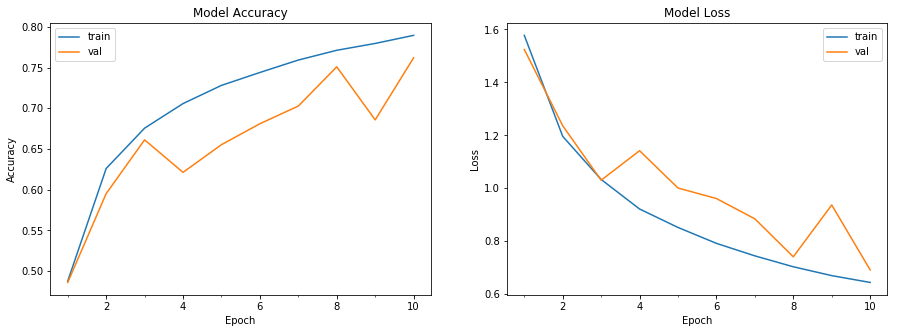

Accuracy on test data is: 76.20


In [9]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Import few other libraries required for Gradcam implementation
---------------------------------------------------------------


In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import sys

Most relevant to our approach is the Class Activation Mapping (CAM) approach to localization. This approach modifies image classification CNN architectures replacing fully-connected layers with convolutional layers and global average pooling ,thus achieving class-specific feature maps. Others have investigated similar methods using global max pooling and log-sum-exp pooling .
A drawback of CAM is that it requires feature maps to directly precede softmax layers, so it is only applicable to a particular kind of CNN architectures performing global average pooling over convolutional maps immediately prior to prediction (i.e. conv feature maps → global average pooling → softmax layer)

![](images/formula.png)


Grad-CAM as a generalization to CAM. Recall that CAM produces a localization map for an image classification CNN with a specific kind of architecture where global average pooled convolutional feature maps are fed directly into softmax. Specifically, let the penultimate layer produce K feature maps, Ak ∈ R u×v . These feature maps are then spatially pooled using Global Average Pooling (GAP) and linearly transformed to produce a score S c for each class c



feature map To produce the localization map for modified image classification architectures, such as above, the order of summations can be interchanged to obtain Lc.

Note that this modification of architecture necessitates retraining because not all architectures have weights w c k connecting features maps to outputs. When Grad-CAM is applied to these architectures α c k = w c k—making Grad-CAM a strict generalization of CAM (see Section A for details). The above generalization also allows us to generate visual explanations from CNN-based models t


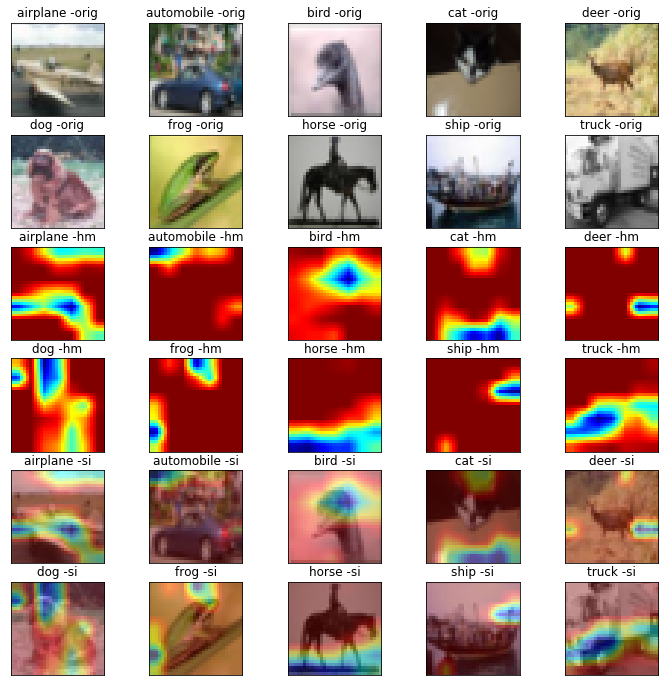

In [0]:
fig = plt.figure(figsize=(12,12))
p =0
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
for i in range(10):
  #if i in [0,1,2, 3,4,5,6,7,8,9]:
  
  img = future_im[i]

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_8")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for j in range(10):
      conv_layer_output_value[:, :, j] *= pooled_grads_value[j]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)


  img = future_im[i]
  #print(img.shape[1])

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  ax = fig.add_subplot(6, 5, 1 + i, xticks=[], yticks=[])
  plt.imshow(img)
  ax.set_title(class_names[i] + " -orig")
  print('')
  ax = fig.add_subplot(6, 5, 11 + i, xticks=[], yticks=[])
  plt.imshow(heatmap)
  ax.set_title(class_names[i] + " -hm")
  print('')
  ax = fig.add_subplot(6, 5, 21 + i, xticks=[], yticks=[])
  p +=1
  plt.imshow(superimposed_img)
  ax.set_title(class_names[i] + " -si")
  
plt.show()

The Image above shows the original Image, The heatmap and the Super imposed images which are formed by including the heatmap over the image .

If we see it clearly then it's visible that the heatmap is looking at a very specific portion of the image to perform detection . This will be more clear when we will see the model that works on the cutout .

So let's park the discussion till we see the network .

Random Eraser Function
-----------------------


Random Erasing is a kind of image augmentation methods for convolutional neural networks (CNN). In this type of method a portion of the image is being cut and some random values between (0-255) is added into those pixels . We will also see by updating the mean instead of the random values 

In [0]:
  def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        #mean_img = np.mean(input_img, axis =(0,1)) 
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

Model Training and Validation with Random eraser/cut out 
-----------------------------------------------------------
Normalize the Images

Fit the images to the model

Calculate the time taken for training

Plot the model parameters

Print the last validation accuracy

Epoch 1/10
  1/390 [..............................] - ETA: 49s - loss: 3.0621 - acc: 0.0859

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=10)`
  # This is added back by InteractiveShellApp.init_path()


390/390 [==============================] - 38s 97ms/step - loss: 2.1338 - acc: 0.2042 - val_loss: 4.2286 - val_acc: 0.1004
Epoch 2/10
390/390 [==============================] - 38s 98ms/step - loss: 1.8491 - acc: 0.3203 - val_loss: 3.0194 - val_acc: 0.1649
Epoch 3/10
390/390 [==============================] - 38s 97ms/step - loss: 1.6950 - acc: 0.3842 - val_loss: 2.1762 - val_acc: 0.2520
Epoch 4/10
390/390 [==============================] - 38s 97ms/step - loss: 1.6079 - acc: 0.4195 - val_loss: 1.8793 - val_acc: 0.3378
Epoch 5/10
390/390 [==============================] - 38s 97ms/step - loss: 1.5333 - acc: 0.4508 - val_loss: 1.3686 - val_acc: 0.5167
Epoch 6/10
390/390 [==============================] - 38s 97ms/step - loss: 1.4760 - acc: 0.4709 - val_loss: 1.7262 - val_acc: 0.3942
Epoch 7/10
390/390 [==============================] - 38s 97ms/step - loss: 1.4341 - acc: 0.4878 - val_loss: 1.3759 - val_acc: 0.5082
Epoch 8/10
390/390 [==============================] - 38s 97ms/step - los

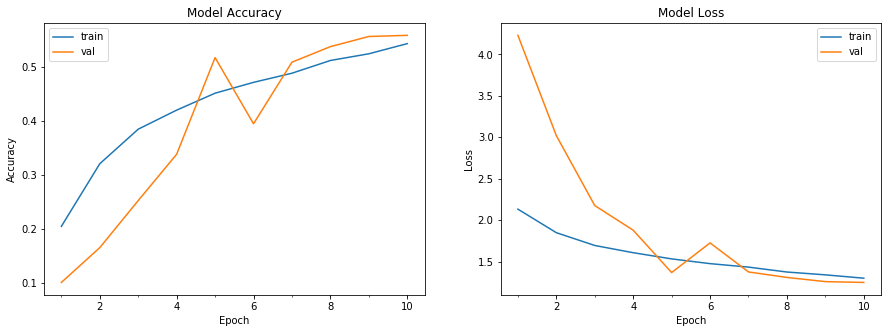

Accuracy on test data is: 55.79


In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, preprocessing_function= get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3,
                  v_l=0, v_h=255, pixel_level=True),
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Display the Images after running the model with random eraser/cutout 
----------------------------------------------------------------------

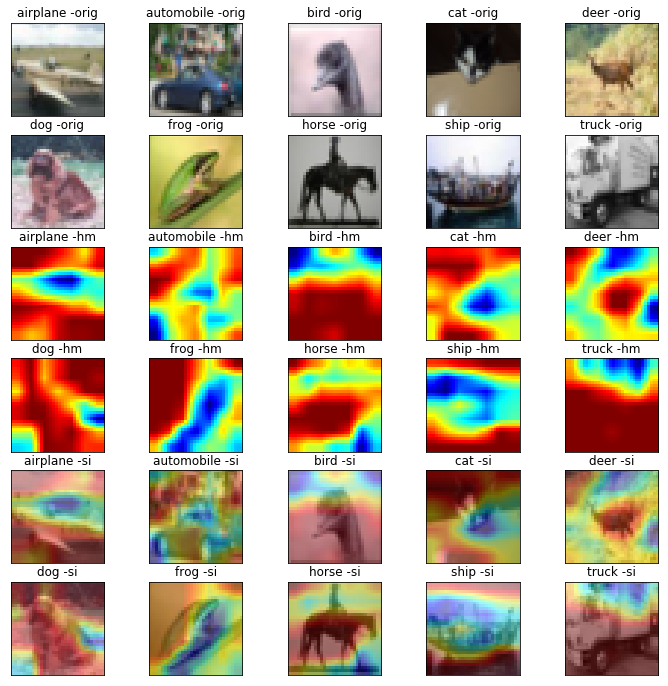

In [0]:
fig = plt.figure(figsize=(12,12))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
p =0
for i in range(10):
  #if i in [0,1,2, 3,4,5,6,7,8,9]:
  
    img = future_im[i]

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("conv2d_8")

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for j in range(10):
        conv_layer_output_value[:, :, j] *= pooled_grads_value[j]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)


    img = future_im[i]
    #print(img.shape[1])

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    ax = fig.add_subplot(6, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(img)
    ax.set_title(class_names[i] + " -orig")
    ax = fig.add_subplot(6, 5, 11 + i, xticks=[], yticks=[])
    plt.imshow(heatmap)
    ax.set_title(class_names[i] + " -hm")
    ax = fig.add_subplot(6, 5, 21 + i, xticks=[], yticks=[])
    p +=1
    plt.imshow(superimposed_img)
    ax.set_title(class_names[i] + " -si")
  
plt.show()

Observation
-------------
It's clearly visible that now the model is looking for almost the entire image instead of looking at a portion of it . This helps the network learn more harder . We may think that why we need it ?

Imagine a situation in which you want to authenticate employess by detecting the face of them which were taken under a good lighting condition and full face of the employee. Now in reality when the employee came into the office there was another employee who was covering 25-50 % of the face of the employee. Now would you like your model not to predict the emploee correctly ?

As it's not possible to know all the situations that may cover the object , so cutout is an excellent method to identify images in such situations and the most effective one as well.


Function to fill Mean for the cutout portion of the image
----------------------------------------------------------

This function is the same except from the fact that this time the pixels of the original image is filled by the mean value of the channel .

Please Note : I am not sure if this is the way we fill mean to the image ( @ Rohan - Please highlight the corrections. The model is probably not showing the best but kept it to understand why ?)

In [0]:
 def cut_out(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def cutout(input_img):
        mean_img = np.mean(input_img, axis =(0,1)) 
        #print(mean_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(mean_img, mean_img, (1, 1, img_c))
        else:
            c = np.random.uniform(mean_img, mean_img)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return cutout

Model Training and Validation with Random eraser/cut out (Mean)
----------------------------------------------------------------
Normalize the Images

Fit the images to the model

Calculate the time taken for training

Plot the model parameters

Print the last validation accuracy

Epoch 1/10
  1/390 [..............................] - ETA: 50s - loss: 1.6025 - acc: 0.4219

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=10)`
  # This is added back by InteractiveShellApp.init_path()


390/390 [==============================] - 38s 97ms/step - loss: 1.1503 - acc: 0.5994 - val_loss: 2.3352 - val_acc: 0.1193
Epoch 2/10
390/390 [==============================] - 38s 97ms/step - loss: 0.9958 - acc: 0.6568 - val_loss: 2.3667 - val_acc: 0.1791
Epoch 3/10
390/390 [==============================] - 38s 97ms/step - loss: 0.9127 - acc: 0.6881 - val_loss: 1.0008 - val_acc: 0.6434
Epoch 4/10
390/390 [==============================] - 38s 96ms/step - loss: 0.8571 - acc: 0.7067 - val_loss: 0.7588 - val_acc: 0.7358
Epoch 5/10
390/390 [==============================] - 38s 97ms/step - loss: 0.8113 - acc: 0.7214 - val_loss: 0.7892 - val_acc: 0.7242
Epoch 6/10
390/390 [==============================] - 38s 97ms/step - loss: 0.7789 - acc: 0.7341 - val_loss: 0.7910 - val_acc: 0.7259
Epoch 7/10
390/390 [==============================] - 38s 97ms/step - loss: 0.7503 - acc: 0.7430 - val_loss: 0.7741 - val_acc: 0.7336
Epoch 8/10
390/390 [==============================] - 38s 97ms/step - los

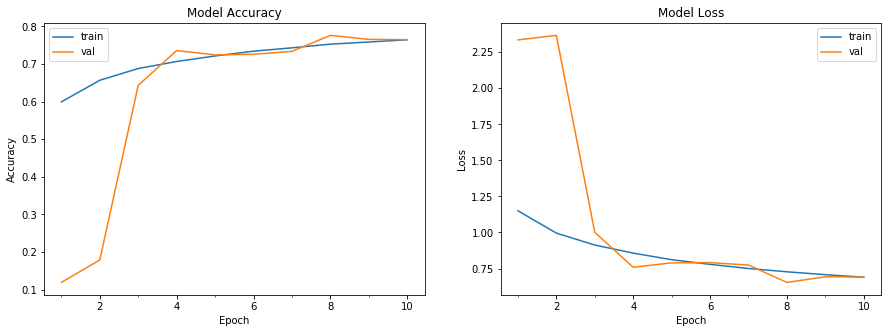

Accuracy on test data is: 76.48


In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, preprocessing_function= cut_out(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3,
                  v_l=0, v_h=255, pixel_level=),
                             horizontal_flip=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Display the images to see how it works
-----------------------------------------

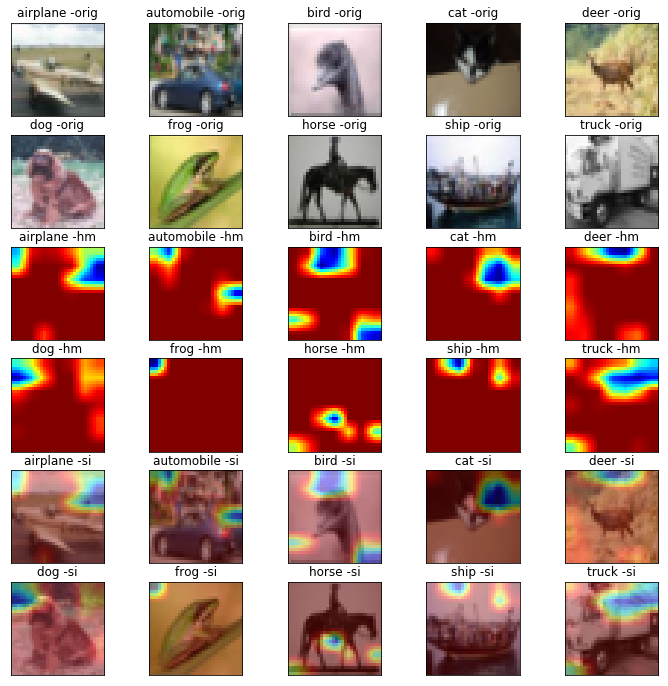

In [0]:
fig = plt.figure(figsize=(12,12))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
p =0
for i in range(10):
  #if i in [0,1,2, 3,4,5,6,7,8,9]:
  
    img = future_im[i]

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("conv2d_8")

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for j in range(10):
        conv_layer_output_value[:, :, j] *= pooled_grads_value[j]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)


    img = future_im[i]
    #print(img.shape[1])

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    ax = fig.add_subplot(6, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(img)
    ax.set_title(class_names[i] + " -orig")
    ax = fig.add_subplot(6, 5, 11 + i, xticks=[], yticks=[])
    plt.imshow(heatmap)
    ax.set_title(class_names[i] + " -hm")
    ax = fig.add_subplot(6, 5, 21 + i, xticks=[], yticks=[])
    p +=1
    plt.imshow(superimposed_img)
    ax.set_title(class_names[i] + " -si")
  
plt.show()

Observation
--------------

I didn't observe any great improvements on the way the cutout should work. But i kept it knowingly to find out if i am doing something wrong (which looks to be the case for now)

So now i am trying to run the same network many more times by changing the parameters . Let's see if i am seeing any difference 

Epoch 1/10
  1/390 [..............................] - ETA: 54s - loss: 0.5776 - acc: 0.8281

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=10)`
  # This is added back by InteractiveShellApp.init_path()


390/390 [==============================] - 38s 98ms/step - loss: 0.7033 - acc: 0.7583 - val_loss: 0.6924 - val_acc: 0.7645
Epoch 2/10
390/390 [==============================] - 38s 98ms/step - loss: 0.6869 - acc: 0.7656 - val_loss: 0.6005 - val_acc: 0.7934
Epoch 3/10
390/390 [==============================] - 38s 97ms/step - loss: 0.6707 - acc: 0.7704 - val_loss: 0.5889 - val_acc: 0.7976
Epoch 4/10
390/390 [==============================] - 38s 98ms/step - loss: 0.6610 - acc: 0.7725 - val_loss: 0.6533 - val_acc: 0.7737
Epoch 5/10
390/390 [==============================] - 38s 98ms/step - loss: 0.6548 - acc: 0.7755 - val_loss: 0.6012 - val_acc: 0.7902
Epoch 6/10
390/390 [==============================] - 38s 98ms/step - loss: 0.6424 - acc: 0.7796 - val_loss: 0.6269 - val_acc: 0.7826
Epoch 7/10
390/390 [==============================] - 38s 98ms/step - loss: 0.6354 - acc: 0.7818 - val_loss: 0.6446 - val_acc: 0.7776
Epoch 8/10
390/390 [==============================] - 38s 98ms/step - los

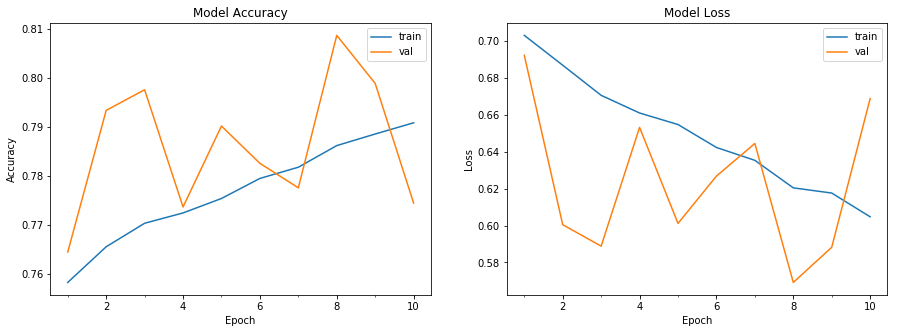

Accuracy on test data is: 77.45


In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, preprocessing_function= cut_out(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3,
                  v_l=0, v_h=255, pixel_level=False),
                             horizontal_flip=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Observation
--------------

The images below are little better but not as good as random erasing . Here i am sensing that a good selection of hyper parameters may give better interpretabilit. Let's find out 


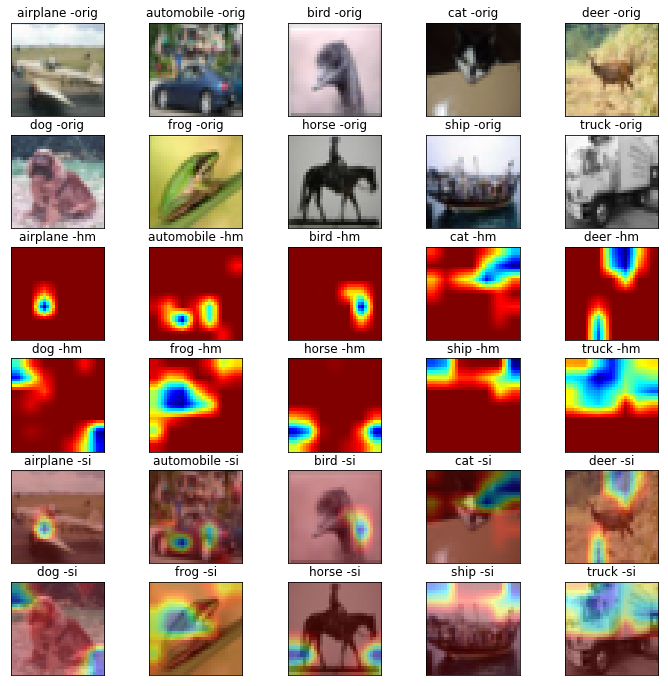

In [0]:
fig = plt.figure(figsize=(12,12))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
p =0
for i in range(10):
  #if i in [0,1,2, 3,4,5,6,7,8,9]:
  
    img = future_im[i]

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("conv2d_8")

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for j in range(10):
        conv_layer_output_value[:, :, j] *= pooled_grads_value[j]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)


    img = future_im[i]
    #print(img.shape[1])

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    ax = fig.add_subplot(6, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(img)
    ax.set_title(class_names[i] + " -orig")
    ax = fig.add_subplot(6, 5, 11 + i, xticks=[], yticks=[])
    plt.imshow(heatmap)
    ax.set_title(class_names[i] + " -hm")
    ax = fig.add_subplot(6, 5, 21 + i, xticks=[], yticks=[])
    p +=1
    plt.imshow(superimposed_img)
    ax.set_title(class_names[i] + " -si")
  
plt.show()

# one more try with different hyper parameters

Epoch 1/10
  1/390 [..............................] - ETA: 51s - loss: 0.6145 - acc: 0.7812

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=10)`
  # This is added back by InteractiveShellApp.init_path()


390/390 [==============================] - 38s 98ms/step - loss: 0.5605 - acc: 0.8097 - val_loss: 0.6005 - val_acc: 0.7956
Epoch 2/10
390/390 [==============================] - 38s 98ms/step - loss: 0.5526 - acc: 0.8119 - val_loss: 0.6274 - val_acc: 0.7811
Epoch 3/10
390/390 [==============================] - 38s 98ms/step - loss: 0.5461 - acc: 0.8162 - val_loss: 0.7169 - val_acc: 0.7595
Epoch 4/10
390/390 [==============================] - 38s 97ms/step - loss: 0.5336 - acc: 0.8158 - val_loss: 0.6024 - val_acc: 0.8007
Epoch 5/10
390/390 [==============================] - 38s 98ms/step - loss: 0.5356 - acc: 0.8167 - val_loss: 0.6006 - val_acc: 0.7967
Epoch 6/10
390/390 [==============================] - 38s 97ms/step - loss: 0.5285 - acc: 0.8203 - val_loss: 0.5069 - val_acc: 0.8250
Epoch 7/10
390/390 [==============================] - 38s 97ms/step - loss: 0.5226 - acc: 0.8204 - val_loss: 0.5856 - val_acc: 0.7979
Epoch 8/10
390/390 [==============================] - 38s 97ms/step - los

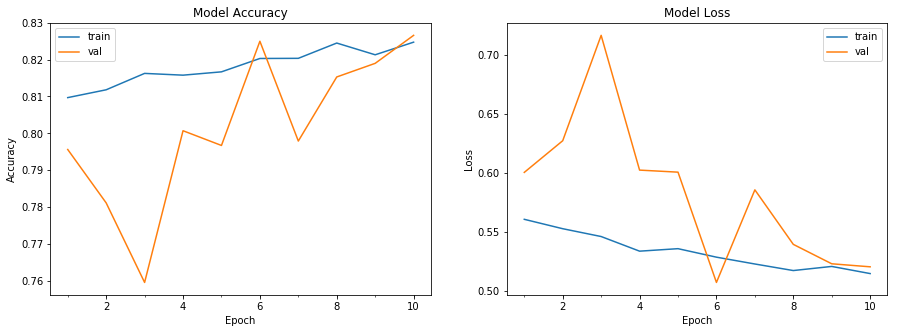

Accuracy on test data is: 82.66


In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, preprocessing_function= cut_out(p=0.5, s_l=0.02, s_h=0.2, r_1=0.4, r_2=1/0.4,
                  v_l=0, v_h=255, pixel_level=False),
                             horizontal_flip=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

This time it looks much better but not as good as random erasing. Lets change the convolution layer once and see if it has any impact

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


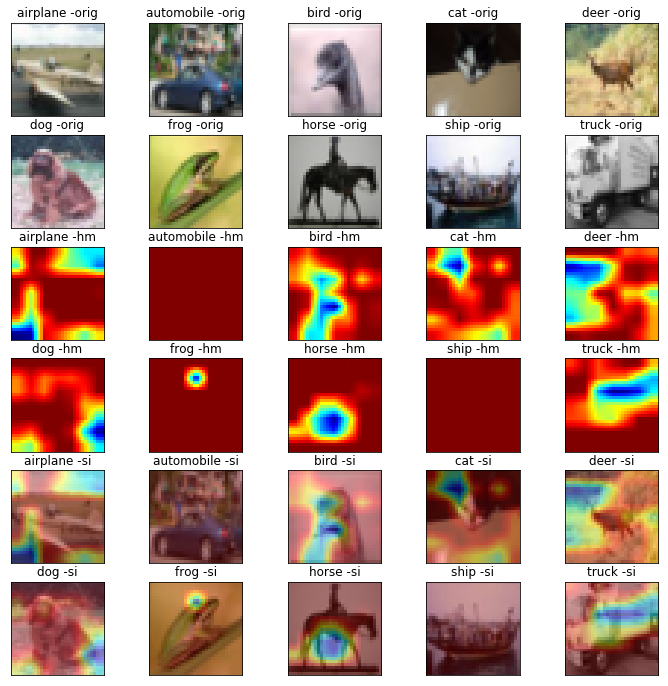

In [0]:
fig = plt.figure(figsize=(12,12))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
p =0
for i in range(10):
  #if i in [0,1,2, 3,4,5,6,7,8,9]:
  
    img = future_im[i]

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("conv2d_8")

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for j in range(10):
        conv_layer_output_value[:, :, j] *= pooled_grads_value[j]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)


    img = future_im[i]
    #print(img.shape[1])

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    #superimposed_img = (img * 0.6 , heatmap * 0.4,0)
    ax = fig.add_subplot(6, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(img)
    ax.set_title(class_names[i] + " -orig")
    ax = fig.add_subplot(6, 5, 11 + i, xticks=[], yticks=[])
    plt.imshow(heatmap)
    ax.set_title(class_names[i] + " -hm")
    ax = fig.add_subplot(6, 5, 21 + i, xticks=[], yticks=[])
    p +=1
    plt.imshow(superimposed_img)
    ax.set_title(class_names[i] + " -si")
  
plt.show()

In [0]:
def cut_out_updt(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def cutout(input_img):
        mean_img = np.mean(input_img, axis =(0,1)) 
        #print(mean_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

#         if p_1 > p:
#             return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(mean_img, mean_img, (1, 1, img_c))
        else:
            c = np.random.uniform(mean_img, mean_img)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return cutout

# This time by chaning from each pixel to image and see what's the result 

Epoch 1/10
  1/390 [..............................] - ETA: 55s - loss: 0.8406 - acc: 0.7344

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=10)`
  # This is added back by InteractiveShellApp.init_path()


390/390 [==============================] - 38s 97ms/step - loss: 0.6654 - acc: 0.7682 - val_loss: 0.5256 - val_acc: 0.8236
Epoch 2/10
390/390 [==============================] - 38s 97ms/step - loss: 0.6616 - acc: 0.7703 - val_loss: 0.5642 - val_acc: 0.8138
Epoch 3/10
390/390 [==============================] - 38s 97ms/step - loss: 0.6604 - acc: 0.7698 - val_loss: 0.5179 - val_acc: 0.8239
Epoch 4/10
390/390 [==============================] - 38s 97ms/step - loss: 0.6481 - acc: 0.7753 - val_loss: 0.4777 - val_acc: 0.8394
Epoch 5/10
390/390 [==============================] - 38s 97ms/step - loss: 0.6446 - acc: 0.7763 - val_loss: 0.4839 - val_acc: 0.8362
Epoch 6/10
390/390 [==============================] - 38s 97ms/step - loss: 0.6384 - acc: 0.7800 - val_loss: 0.5152 - val_acc: 0.8286
Epoch 7/10
390/390 [==============================] - 38s 97ms/step - loss: 0.6419 - acc: 0.7769 - val_loss: 0.5206 - val_acc: 0.8276
Epoch 8/10
390/390 [==============================] - 38s 97ms/step - los

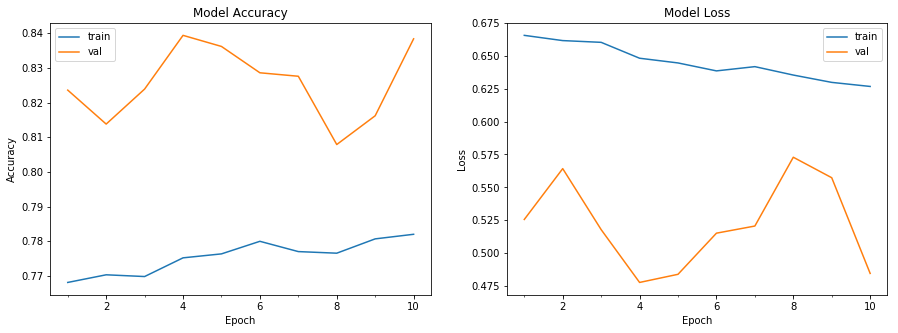

Accuracy on test data is: 83.84


In [0]:
datagen = ImageDataGenerator(zoom_range=0.0, preprocessing_function= cut_out_updt(p=0.5, s_l=0.1, s_h=0.4, r_1=0.2, r_2=1/0.2,
                  v_l=0, v_h=255, pixel_level=False),
                             horizontal_flip=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Observation
-------------
I am not seeing any great change over what we got last time . Let's change something else and see

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


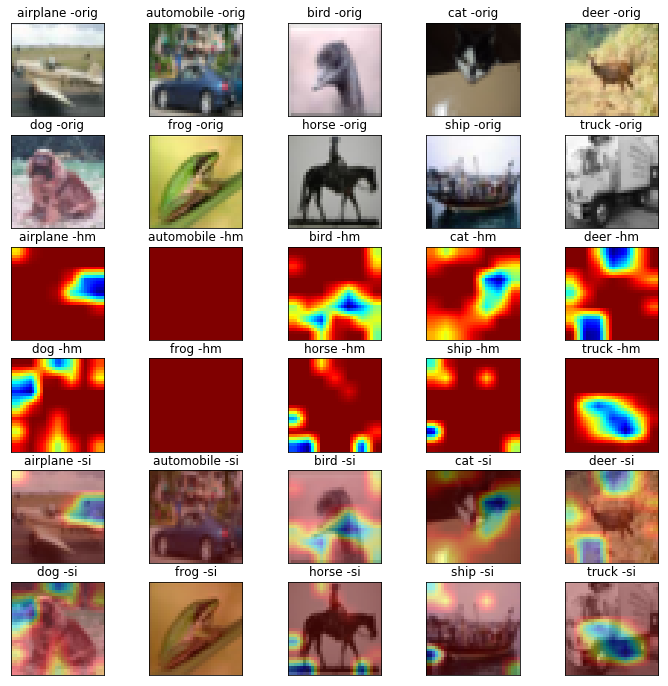

In [0]:
fig = plt.figure(figsize=(12,12))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
p =0
for i in range(10):
  #if i in [0,1,2, 3,4,5,6,7,8,9]:
  
    img = future_im[i]

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("conv2d_8")

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for j in range(10):
        conv_layer_output_value[:, :, j] *= pooled_grads_value[j]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)


    img = future_im[i]
    #print(img.shape[1])

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    #superimposed_img = (img * 0.6 , heatmap * 0.4,0)
    ax = fig.add_subplot(6, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(img)
    ax.set_title(class_names[i] + " -orig")
    ax = fig.add_subplot(6, 5, 11 + i, xticks=[], yticks=[])
    plt.imshow(heatmap)
    ax.set_title(class_names[i] + " -hm")
    ax = fig.add_subplot(6, 5, 21 + i, xticks=[], yticks=[])
    p +=1
    plt.imshow(superimposed_img)
    ax.set_title(class_names[i] + " -si")
  
plt.show()

Observation
-------------

I am getting a warning 
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide

which normally comes when we try to divide by zero or Nan. I am not sure why am i getting this. I am keeping this here knowingly.(@ Rohan - Please review and let me know the reason behind this and where am i going wrong, Thanks )

Change the Convolution layer to n-1 th layer
----------------------------------------------

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


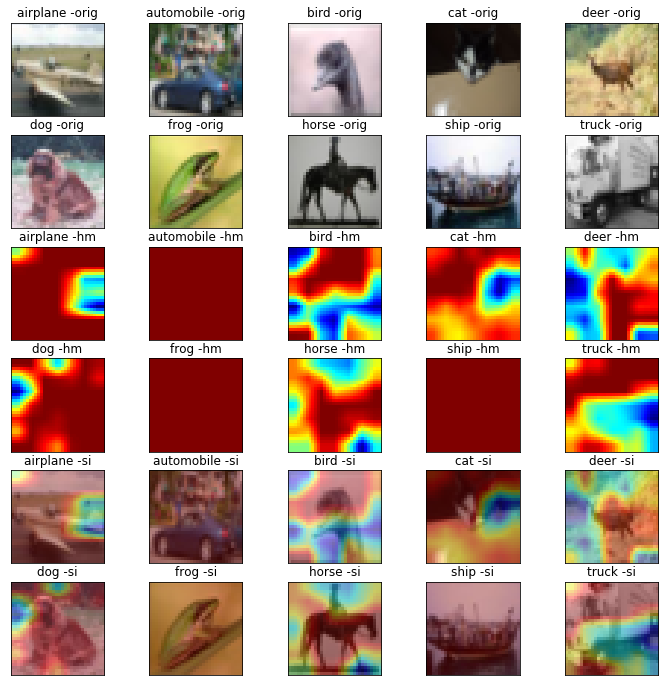

In [0]:
fig = plt.figure(figsize=(12,12))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
p =0
for i in range(10):
  #if i in [0,1,2, 3,4,5,6,7,8,9]:
  
    img = future_im[i]

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("conv2d_7")

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for j in range(128):
        conv_layer_output_value[:, :, j] *= pooled_grads_value[j]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)


    img = future_im[i]
    #print(img.shape[1])

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    #superimposed_img = (img * 0.6 , heatmap * 0.4,0)
    ax = fig.add_subplot(6, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(img)
    ax.set_title(class_names[i] + " -orig")
    ax = fig.add_subplot(6, 5, 11 + i, xticks=[], yticks=[])
    plt.imshow(heatmap)
    ax.set_title(class_names[i] + " -hm")
    ax = fig.add_subplot(6, 5, 21 + i, xticks=[], yticks=[])
    p +=1
    plt.imshow(superimposed_img)
    ax.set_title(class_names[i] + " -si")
  
plt.show()

Observation
--------------

The images are in the same type as before . We will try our experiments again but for now I am submitting the assignment 

Summary
--------

![](images/cs_stats.png)
We ran networks with and without cutout . This is clearly evident that cutout is a great generalization method . That is the reason why many state of the art models are using it extensively .

We will continue our research on this topic and update as applicable

******** Nihar ************

New Network ( This code is a copy from my friend's Assignment)
-----------------------------------------------------------------
The difference I see in this network is 

1. He was reading the Images using the image numbers from the Test data set
2. The step which converts into an multi dimensional array and Preprocessing step while calculating Gradcam is not there (it's not required in this case )
3. The Weightsharing step "cv2.addWeighted(img, 0.6, heatmap, 0.2, 0)" was giving error . Hence he used superimposed_img = heatmap*0.4+img * 0.6 instead


In [0]:
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
import keras.backend as K
import numpy as np
import cv2
import sys

import random
random_imgs = random.sample(range(1, 1000), 5)
random_imgs = [884, 249, 293, 371, 423]

orig_imgs = []
mod_imgs = []
heat_imgs = []

for img_idx in random_imgs:
  x = np.expand_dims(test_features[img_idx], axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_7")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
    #plt.matshow(heatmap)
  img = test_features[img_idx]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  #superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  #superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  superimposed_img = heatmap*0.4+img*0.6
  #superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  #cv2_imshow(img)
  #cv2_imshow(superimposed_img)
  orig_imgs.append(img)
  mod_imgs.append(superimposed_img)
  heat_imgs.append(heatmap)
  cv2.waitKey(0)






Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


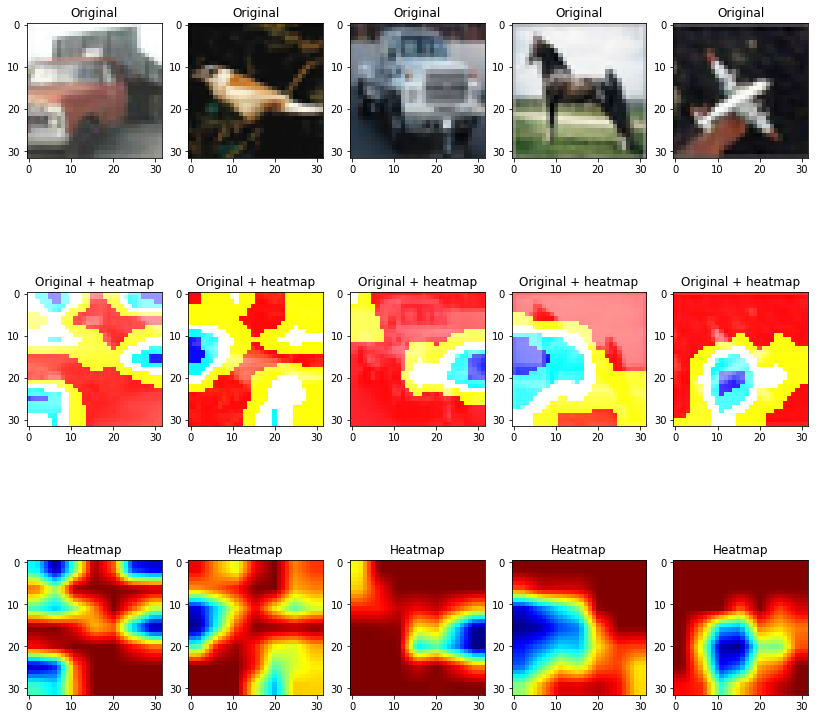

In [11]:
img_list = orig_imgs + mod_imgs + heat_imgs

# settings
h, w = 5, 5       # for raster image
nrows, ncols = 3, 5  # array of sub-plots
figsize = [14,14]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

for i, axi in enumerate(ax.flat):
    if i < 5:
      
      axi.set_title("Original")
    elif i <10 :
      axi.set_title("Original + heatmap")
    else:
      axi.set_title("Heatmap")
    
    axi.imshow(img_list[i])

Observations
--------------
Activation for

1st picture : car is wheel

2nd picture : bird is body and surroundings

3nd picture : car is front body

4th picture : horse is tail and top part of leg

5th picture : plane is the shape

Run 2 - with cutout
--------------------------
Rerunning the model with cutout

Enabled it as a part of the Datagen generator

In [0]:
##Random cutoff

random_erasing = True
pixel_level = False

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

Epoch 1/10
  1/390 [..............................] - ETA: 51s - loss: 0.7792 - acc: 0.7500

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=10)`
  if sys.path[0] == '':


390/390 [==============================] - 39s 99ms/step - loss: 0.8370 - acc: 0.7176 - val_loss: 0.8937 - val_acc: 0.6984
Epoch 2/10
390/390 [==============================] - 38s 98ms/step - loss: 0.7914 - acc: 0.7326 - val_loss: 0.7533 - val_acc: 0.7483
Epoch 3/10
390/390 [==============================] - 39s 99ms/step - loss: 0.7642 - acc: 0.7415 - val_loss: 0.6856 - val_acc: 0.7663
Epoch 4/10
390/390 [==============================] - 39s 99ms/step - loss: 0.7454 - acc: 0.7491 - val_loss: 0.6579 - val_acc: 0.7764
Epoch 5/10
390/390 [==============================] - 39s 99ms/step - loss: 0.7227 - acc: 0.7560 - val_loss: 0.7909 - val_acc: 0.7295
Epoch 6/10
390/390 [==============================] - 39s 100ms/step - loss: 0.7084 - acc: 0.7600 - val_loss: 0.7378 - val_acc: 0.7492
Epoch 7/10
390/390 [==============================] - 39s 99ms/step - loss: 0.6935 - acc: 0.7656 - val_loss: 0.6685 - val_acc: 0.7689
Epoch 8/10
390/390 [==============================] - 39s 99ms/step - lo

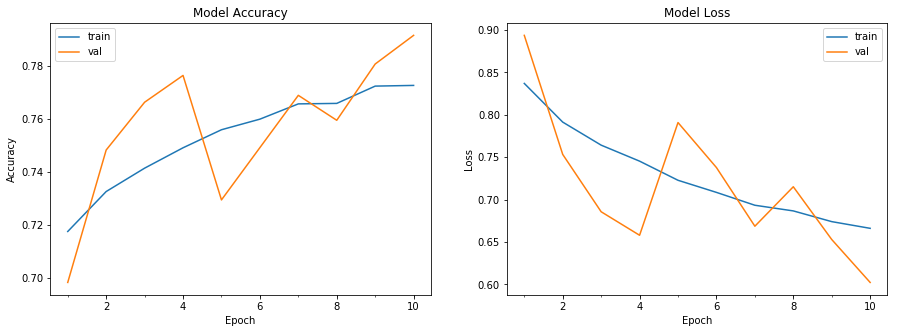

Accuracy on test data is: 79.15


In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=True, preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=pixel_level))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 10, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


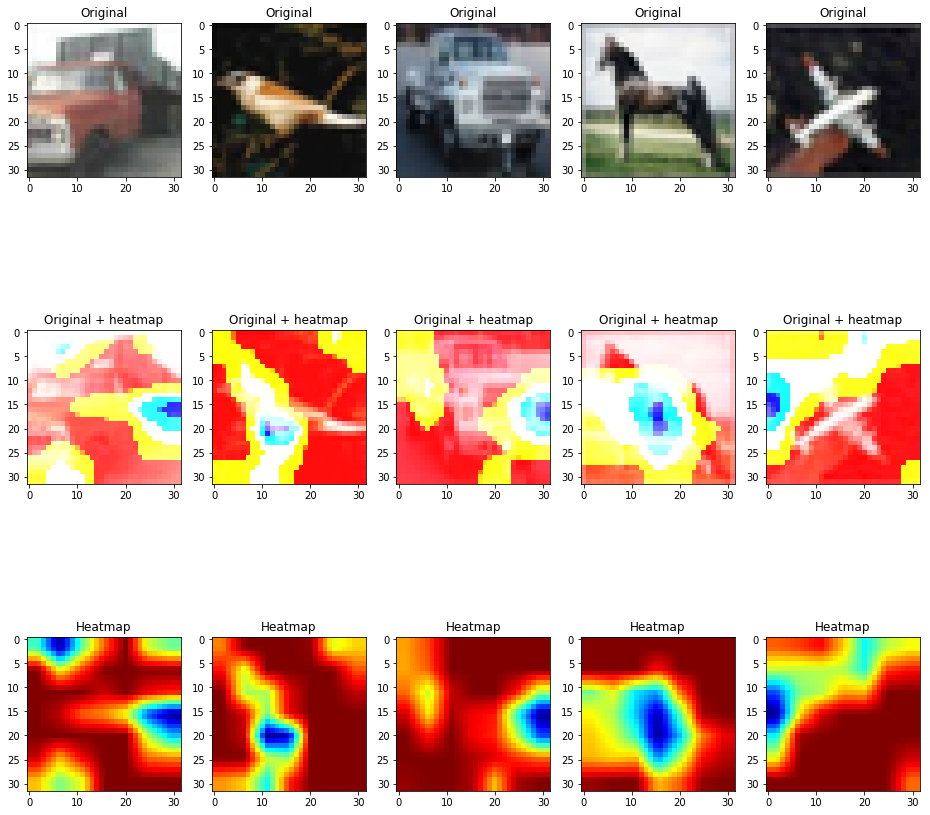

In [15]:
random_imgs = [884, 249, 293, 371, 423]

orig_imgs = []
mod_imgs = []
heat_imgs = []

for img_idx in random_imgs:
  x = np.expand_dims(test_features[img_idx], axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_7")
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
    #plt.matshow(heatmap)
  img = test_features[img_idx]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  #superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  #superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  superimposed_img = heatmap*0.1+img
  #superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.2, 0)
  #cv2_imshow(img)
  #cv2_imshow(superimposed_img)
  orig_imgs.append(img)
  mod_imgs.append(superimposed_img)
  heat_imgs.append(heatmap)
  cv2.waitKey(0)

img_list = orig_imgs + mod_imgs + heat_imgs

# settings
h, w = 5, 5       # for raster image
nrows, ncols = 3, 5  # array of sub-plots
figsize = [16,16]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

for i, axi in enumerate(ax.flat):
  if i < 5:
      
    axi.set_title("Original")
  elif i <10 :
    axi.set_title("Original + heatmap")
  else:
    axi.set_title("Heatmap")

  axi.imshow(img_list[i])

Observations and Learning (After Cutout)
--------------------------------------------
The gap between training accuracy and validation accuray is small. This would imply cutout significantly helped in generalizing and reduce overfitting.

We can clearly see that the activations become more generic after cutout. This means the network is able to do a better job predicting using general features

Activation for cutout

1st picture : truck - the fron portion

2nd picture : bird changed to surroundings and tail

3nd picture : car was wheels ( earlier was front body)

4th picture : horse is top part of leg and surrounding

5th picture : plane more specific fin and wing


Question 
------------

I can see that the images are over exposed and not visible unlike the other images . Is this the right way to see Gradcam ? 

